In [1]:
import os
import time
import json
import datetime
import numpy as np
import pandas as pd
import pickle
from datetime import datetime

In [19]:
import seaborn as sns
from plotly import express as px
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
%%time
submit = json.load(open('./data/sample_submission/sample_submission.json', 'r', encoding='utf8')) 
df_dic = pickle.load(open('./mydata/df_dic.plk','rb'))
plc_lst = pickle.load(open('./mydata/plc_lst.plk','rb'))
fct_lst = ['pH', 'COD', 'SS', 'N', 'P', 'T']

CPU times: user 858 ms, sys: 112 ms, total: 970 ms
Wall time: 970 ms


In [4]:
%%time
''' fillna : 단순 missing value 채움'''
for plc in plc_lst:
    df = df_dic[plc]
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')    
    df_dic[plc] = df.dropna()
    
    if df_dic[plc].isna().any().any():
        print(plc)

CPU times: user 2.41 s, sys: 3.45 ms, total: 2.41 s
Wall time: 2.41 s


  0%|          | 0/545 [00:00<?, ?it/s]

/ssd/jaewoo/anaconda3/envs/ts/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/ssd/jaewoo/anaconda3/envs/ts/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50872 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/ssd/jaewoo/anaconda3/envs/ts/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45224 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/ssd/jaewoo/anaconda3/envs/ts/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/ssd/jaewoo/anaconda3/envs/ts/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/ssd/jaewoo/anaconda3/envs/ts/lib/python3.9/site-p

FileNotFoundError: [Errno 2] No such file or directory: './plt_data/ph/서울서남하수__pH.png'

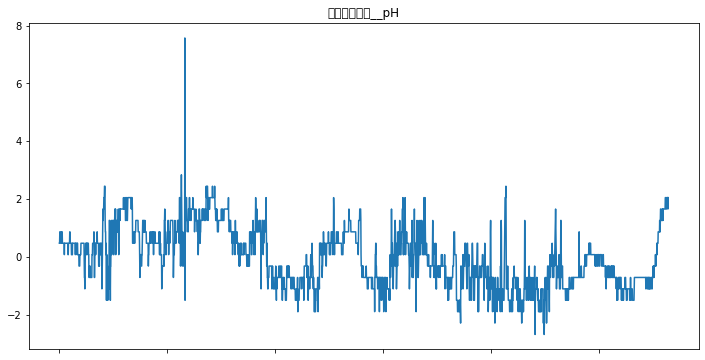

In [23]:
%%time
for i in tqdm(plc_lst):
    plc_df= df_dic[i]
    for f in fct_lst:
        df= plc_df[f]
        fig, ax = plt.subplots(1, 1, figsize = (12,6))


        g1 = sns.lineplot(x= range(len(df)), y= df.values ,ax = ax)
        g1.set(xticklabels=[])
        g1.set(title=f'{i}__{f}')
        g1.set(xlabel=None)
   
        ff = g1.get_figure()
        ff.savefig(f'./plot_data/{f.lower()}/{i}_{f}.png') 

[Text(0.5, 0, '')]

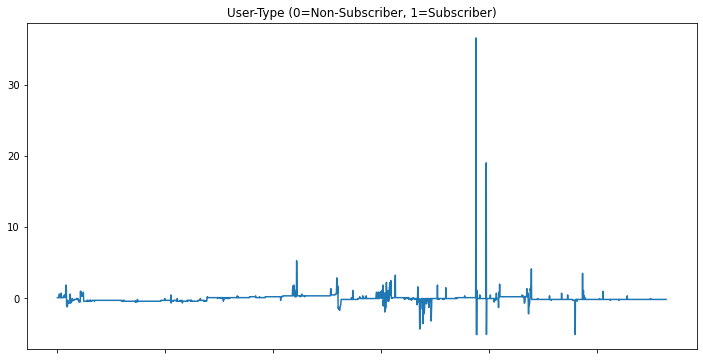

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (12,6))


g1 = sns.lineplot(x= range(len(df)), y= df.values ,ax = ax)
g1.set(xticklabels=[])
g1.set(title=f'{i}__{f}')
g1.set(xlabel=None)

In [ ]:
''' 전체 통채로 만들기 '''
plc_sorted_lst = sorted(plc_lst)

dfs = []
for lo in plc_sorted_lst:
    df_temp = df_dic[lo]
    df_temp['loc'] = lo
    dfs.append(df_temp)
dfall = pd.concat(dfs)

In [44]:
''' 기록이 시작되는 공통 날짜 구하기 '''
dates = []
for lo in plc_sorted_lst:
    df_temp = df_dic[lo]
    dates.append(df_temp.ds[0])
mx_date= max(dates)
print(mx_date)  

20150423


In [50]:
''' 최소 날짜가 포함되어 있는지 확인. -> 모두 포함되어 있다. '''
for lo in plc_sorted_lst:
    df_temp = df_dic[lo]
    if ~(df_temp.ds == mx_date).any():
        print(lo)

In [73]:
''' datetime  열 만들기 '''
dt_list =  [ datetime.strptime(x, "%Y%m%d")for x in  list(dfall['ds'])]
dfall['dst'] = dt_list

''' 공통 날짜로 맞추기 '''
dfall_comm = dfall.loc[dfall.dst >= datetime(2015,4,23)]
dfall_comm = dfall_comm.reset_index(drop=True)

In [74]:
''' 모든 업장의 데이터 길이가 같은지 확인 -> 1015 개로 똑같다. '''
res = dfall_comm.groupby(by = 'loc').size()

In [84]:
for col in ['pH', 'COD', 'SS', 'N', 'P', 'T']:
    dfall_comm[col] = pd.to_numeric(dfall_comm[col])

In [86]:
pickle.dump(dfall_comm , open('./mydata/dfall_comm.plk','wb'))

---
## 6개의 피쳐끼리 corr 보기 

In [87]:
dfall_comm.columns

Index(['ds', 'pH', 'COD', 'SS', 'N', 'P', 'T', 'loc', 'dst'], dtype='object')

In [88]:
df_corr = dfall_comm[['pH', 'COD', 'SS', 'N', 'P', 'T']]

In [89]:
df_corr.corr('pearson')

,pH,COD,SS,N,P,T
pH,1.000000,0.030939,-0.012424,-0.037054,0.019180,0.004092
COD,0.030939,1.000000,0.157425,0.131255,0.101528,0.008062
SS,-0.012424,0.157425,1.000000,0.116247,0.094190,0.000653
N,-0.037054,0.131255,0.116247,1.000000,0.123518,-0.007270
P,0.019180,0.101528,0.094190,0.123518,1.000000,0.011217
T,0.004092,0.008062,0.000653,-0.007270,0.011217,1.000000


---
## 시각화로 확인

In [ ]:
%%time
''' fillna : 단순 missing value 채움'''
for plc in plc_lst:
    df = df_dic[plc]
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')    
    df_dic[plc] = df.dropna()
    
    if df_dic[plc].isna().any().any():
        print(plc)

In [28]:
dfs = []
for lo in plc_sorted_lst:
    df_temp = df_dic[lo]
    df_temp['loc'] = lo
    dfs.append(df_temp)

In [22]:
dfall = pd.concat(dfs)

In [ ]:

fig = px.line(dfall, x="ds", y="pH", color='loc')
fig.show()